In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import networkx as nx
import plotly.graph_objects as go

In [3]:
file_path = "Student Survey - Jan.xlsx"
xls = pd.ExcelFile(file_path)

In [30]:
# Load participants
participants = pd.read_excel(xls, sheet_name="participants")
participants = participants.set_index('Participant-ID')

# List of network sheet names
network_sheets = [
    'net_0_Friends',
    'net_1_Influential',
    'net_2_Feedback',
    'net_3_MoreTime',
    'net_4_Advice',
    'net_5_Disrespect'
]

Friendship network graphs

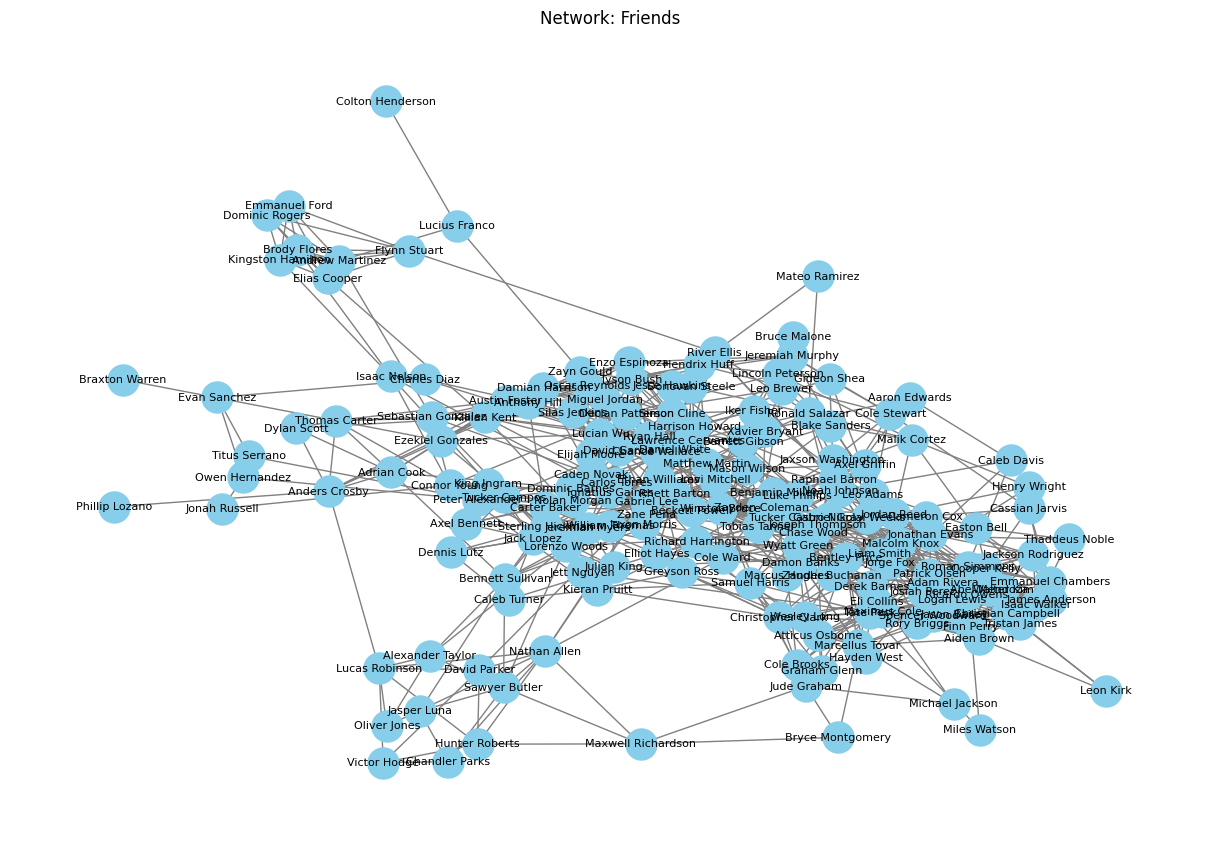

In [31]:
# Load the specific network: net_0_friends
friend_edges_df = pd.read_excel(xls, sheet_name='net_0_Friends')

# Create the graph
friend_edges = nx.Graph()

# Add edges and node attributes
for idx, row in friend_edges_df.iterrows():
    source = row['Source']  # Adjust column names if they are different
    target = row['Target']

    for node in [source, target]:
        if node not in friend_edges:
            if node in participants.index:
                first_name = participants.loc[node, 'First-Name']
                last_name = participants.loc[node, 'Last-Name']
                friend_edges.add_node(node, label=f"{first_name} {last_name}")
            else:
                friend_edges.add_node(node, label="Unknown")

    friend_edges.add_edge(source, target)

friend_edges.remove_edges_from(nx.selfloop_edges(friend_edges))

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(friend_edges, seed=42)  # Layout algorithm

labels = nx.get_node_attributes(friend_edges, 'label')

nx.draw(friend_edges, pos, with_labels=True, labels=labels,
        node_color='skyblue', node_size=500, font_size=8, edge_color='gray')

plt.title('Network: Friends')
plt.show()

In [6]:
# Making interaction: hover to see names

# Get positions (layout)
pos = nx.spring_layout(friend_edges, seed=42)

# Extract node positions
x_nodes = [pos[k][0] for k in friend_edges.nodes()]
y_nodes = [pos[k][1] for k in friend_edges.nodes()]

# Create edges
edge_x = []
edge_y = []

for edge in friend_edges.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Create nodes
node_trace = go.Scatter(
    x=x_nodes, y=y_nodes,
    mode='markers+text',
    hoverinfo='text',
    textposition='top center',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2),
    text=[friend_edges.nodes[n]['label'] for n in friend_edges.nodes()],
)

# Node color = degree
node_adjacencies = []
node_text = []
for node in friend_edges:
    adjacencies = len(friend_edges.adj[node])
    node_adjacencies.append(adjacencies)
    node_text.append(friend_edges.nodes[node]['label'])

node_trace.marker.color = node_adjacencies

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Friend Network',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[dict(
                    text="Interactive NetworkX + Plotly",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 )],
                xaxis=dict(showgrid=False, zeroline=False),
                yaxis=dict(showgrid=False, zeroline=False))
                )

fig.show()

In [7]:
# Layout for node positions
pos = nx.spring_layout(friend_edges, seed=50)

# Edge coordinates
edge_x, edge_y = [], []
for edge in friend_edges.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Node coordinates + hover text only
node_x, node_y, node_text = [], [], []
for node in friend_edges.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    label = friend_edges.nodes[node].get('label', str(node))
    node_text.append(label)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',  # <- No always-visible labels!
    hoverinfo='text',
    text=node_text,
    marker=dict(
        color='skyblue',
        size=20,
        line_width=2
    )
)

# Final figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Interactive Network: Friends',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                )
               )

fig.show()

In [8]:
# Kamada-Kawai prevents overlaps better than spring_layout
pos = nx.kamada_kawai_layout(friend_edges)

# === Compute degree centrality ===
degree_dict = nx.degree_centrality(friend_edges)

# === Edge trace ===
edge_x, edge_y = [], []
for source, target in friend_edges.edges():
    x0, y0 = pos[source]
    x1, y1 = pos[target]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='lightgray'),
    hoverinfo='none',
    mode='lines'
)

# === Node positioning and attribute-enhanced tooltips ===
node_x, node_y, node_text, node_size, node_color = [], [], [], [], []

for node in friend_edges.nodes():
    x, y = pos[node]
    label = friend_edges.nodes[node].get('label', str(node))
    centrality = degree_dict.get(node, 0)
    degree = friend_edges.degree[node]

    # Default values in case of missing data
    effort = attendance = academic = 'N/A'

    if node in participants.index:
        effort = participants.loc[node, 'Perc_Effort']
        attendance = participants.loc[node, 'Attendance']
        academic = participants.loc[node, 'Perc_Academic']

    hover_label = (
        f"<b>{label}</b><br>"
        f"Connections: {degree}<br>"  # ← shows number of edges
        f"Effort: {effort}<br>"
        f"Attendance: {attendance}<br>"
        f"Academic Performance: {academic}"
    )

    node_x.append(x)
    node_y.append(y)
    node_text.append(hover_label)
    node_size.append(10 + centrality * 50)
    node_color.append(centrality)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='Blues',
        cmin=0,
        cmax=max(node_color) if node_color else 1,
        colorbar=dict(
            title='Degree Centrality',
            thickness=15,
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=1, color='gray'),
        opacity=0.9
    )
)

# === Final plot ===
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Interactive Network: Friends (Centrality Size + Shade)",
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

fig.show()

In [13]:
fig.write_html("friend_network_graph.html", full_html=True, include_plotlyjs='cdn')

Influence network graphs

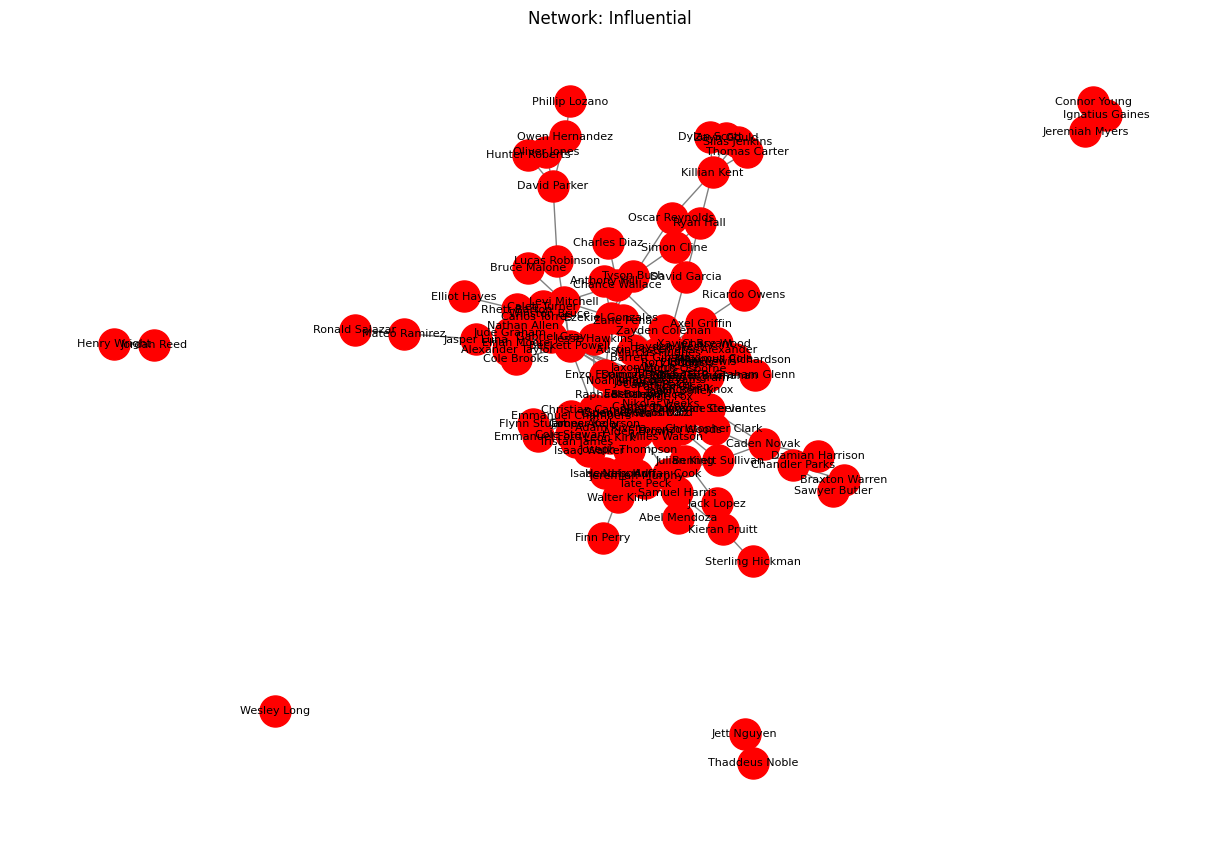

In [14]:
# Load the specific network: net_1_influential
influential_edges_df = pd.read_excel(xls, sheet_name='net_1_Influential')

# Create the graph
influential_edges = nx.Graph()

# Add edges and node attributes
for idx, row in influential_edges_df.iterrows():
    source = row['Source']  # Adjust column names if they are different
    target = row['Target']

    for node in [source, target]:
        if node not in influential_edges:
            if node in participants.index:
                first_name = participants.loc[node, 'First-Name']
                last_name = participants.loc[node, 'Last-Name']
                influential_edges.add_node(node, label=f"{first_name} {last_name}")
            else:
                influential_edges.add_node(node, label="Unknown")

    influential_edges.add_edge(source, target)

influential_edges.remove_edges_from(nx.selfloop_edges(influential_edges))

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(influential_edges, seed=42)  # Layout algorithm

labels = nx.get_node_attributes(influential_edges, 'label')

nx.draw(influential_edges, pos, with_labels=True, labels=labels,
        node_color='red', node_size=500, font_size=8, edge_color='gray')

plt.title('Network: Influential')
plt.show()

In [16]:
# Use Kamada-Kawai layout to reduce overlap
pos = nx.kamada_kawai_layout(influential_edges)

# === Edge trace ===
edge_x, edge_y = [], []
for source, target in influential_edges.edges():
    x0, y0 = pos[source]
    x1, y1 = pos[target]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='lightgray'),
    hoverinfo='none',
    mode='lines'
)

# === Node trace ===
node_x, node_y, node_text = [], [], []
node_size, node_color = [], []

# Get degree for each node
node_degrees = dict(influential_edges.degree())

for node in influential_edges.nodes():
    x, y = pos[node]
    label = influential_edges.nodes[node].get('label', str(node))
    degree = node_degrees.get(node, 0)

    node_x.append(x)
    node_y.append(y)
    node_size.append(5 + degree * 2)       # Size scaled by degree
    node_color.append(degree)              # Color intensity scaled by degree

    hover_label = f"<b>{label}</b><br>Connections: {degree}"
    node_text.append(hover_label)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='Reds',
        cmin=0,
        cmax=max(node_color) if node_color else 1,
        colorbar=dict(
            title='Connections',
            thickness=15,
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=1, color='gray'),
        opacity=0.9
    )
)

# === Final plot ===
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Interactive Network: Influential Connections",
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

fig.show()

In [17]:
fig.write_html("influence_network_graph.html", full_html=True, include_plotlyjs='cdn')

Feedback network graph

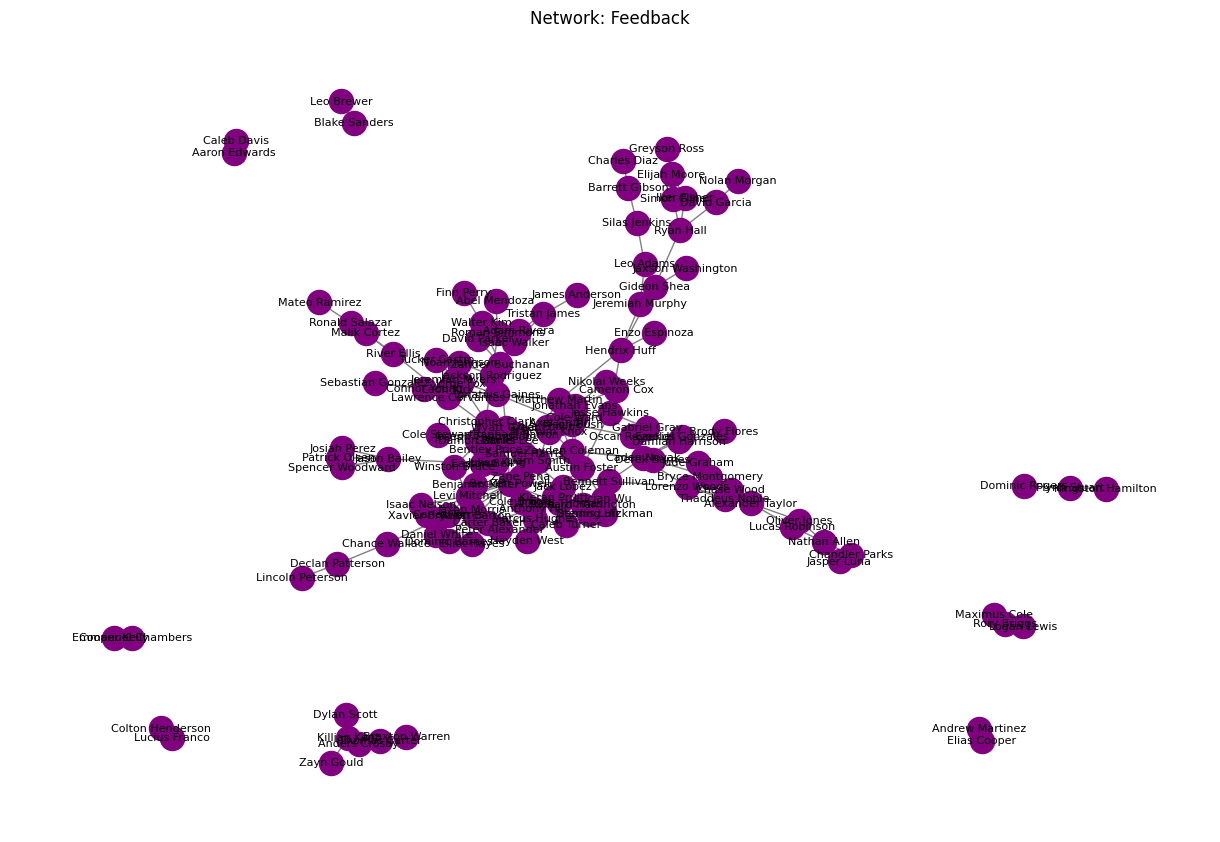

In [10]:
# Load the specific network: net_2_feedback
feedback_edges_df = pd.read_excel(xls, sheet_name='net_2_Feedback')

# Create the graph
feedback_edges = nx.Graph()

# Add edges and node attributes
for idx, row in feedback_edges_df.iterrows():
    source = row['Source']  # Adjust column names if they are different
    target = row['Target']

    for node in [source, target]:
        if node not in feedback_edges:
            if node in participants.index:
                first_name = participants.loc[node, 'First-Name']
                last_name = participants.loc[node, 'Last-Name']
                feedback_edges.add_node(node, label=f"{first_name} {last_name}")
            else:
                feedback_edges.add_node(node, label="Unknown")

    feedback_edges.add_edge(source, target)

feedback_edges.remove_edges_from(nx.selfloop_edges(feedback_edges))

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(feedback_edges, seed=100)  # Layout algorithm

labels = nx.get_node_attributes(feedback_edges, 'label')

nx.draw(feedback_edges, pos, with_labels=True, labels=labels,
        node_color='purple', node_size=300, font_size=8, edge_color='gray')

plt.title('Network: Feedback')
plt.show()

In [11]:
# Use Kamada-Kawai layout to reduce overlap
pos = nx.kamada_kawai_layout(feedback_edges)

# === Edge trace ===
edge_x, edge_y = [], []
for source, target in feedback_edges.edges():
    x0, y0 = pos[source]
    x1, y1 = pos[target]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='lightgray'),
    hoverinfo='none',
    mode='lines'
)

# === Node trace ===
node_x, node_y, node_text = [], [], []
node_size, node_color = [], []

# Get degree for each node
node_degrees = dict(feedback_edges.degree())

for node in feedback_edges.nodes():
    x, y = pos[node]
    label = feedback_edges.nodes[node].get('label', str(node))
    degree = node_degrees.get(node, 0)

    node_x.append(x)
    node_y.append(y)
    node_size.append(5 + degree * 2)       # Size scaled by degree
    node_color.append(degree)              # Color intensity scaled by degree

    hover_label = f"<b>{label}</b><br>Connections: {degree}"
    node_text.append(hover_label)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='Purples',
        cmin=0,
        cmax=max(node_color) if node_color else 1,
        colorbar=dict(
            title='Connections',
            thickness=15,
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=1, color='gray'),
        opacity=0.9
    )
)

# === Final plot ===
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Interactive Network: Feedback-Seeking Connections",
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

fig.show()

In [18]:
fig.write_html("feedback_network_graph.html", full_html=True, include_plotlyjs='cdn')

MoreTime network graph

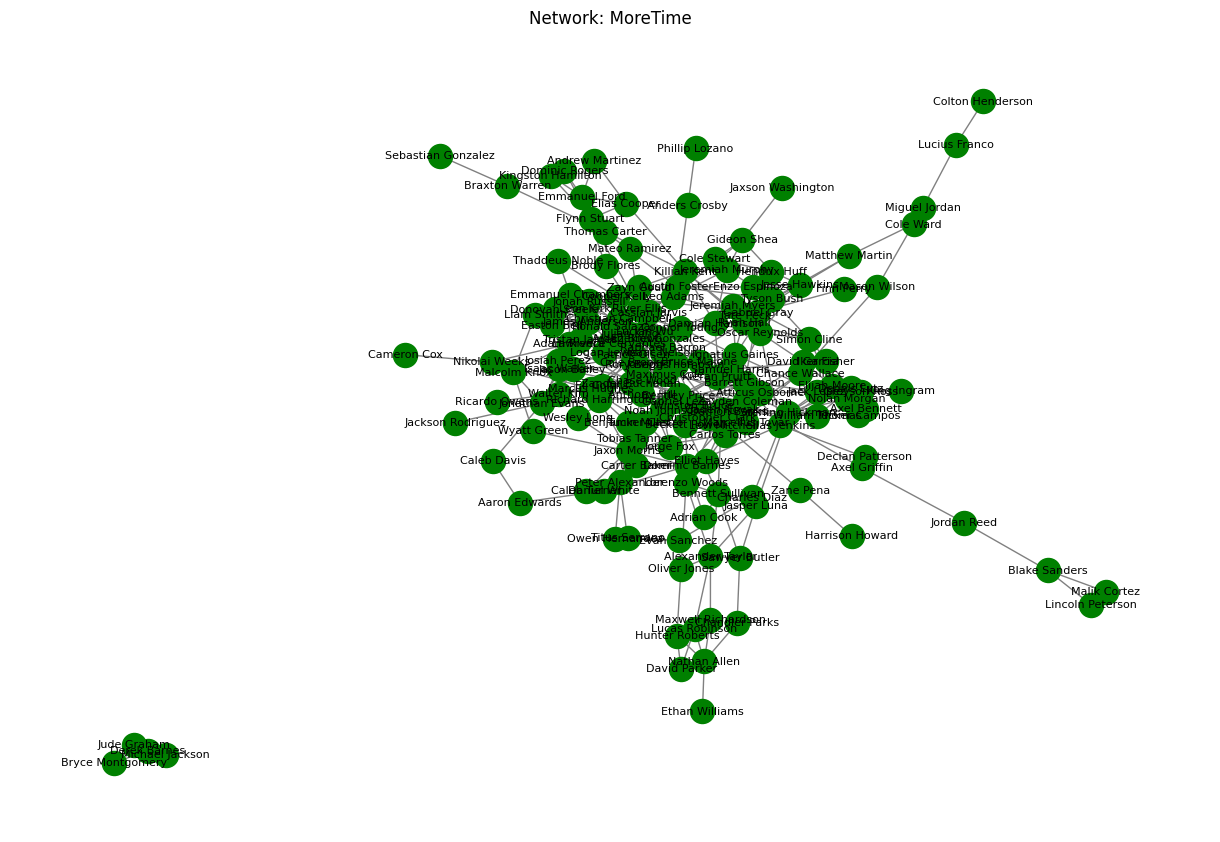

In [19]:
# Load the specific network: net_3_moretime
moretime_edges_df = pd.read_excel(xls, sheet_name='net_3_MoreTime')

# Create the graph
moretime_edges = nx.Graph()

# Add edges and node attributes
for idx, row in moretime_edges_df.iterrows():
    source = row['Source']  # Adjust column names if they are different
    target = row['Target']

    for node in [source, target]:
        if node not in moretime_edges:
            if node in participants.index:
                first_name = participants.loc[node, 'First-Name']
                last_name = participants.loc[node, 'Last-Name']
                moretime_edges.add_node(node, label=f"{first_name} {last_name}")
            else:
                moretime_edges.add_node(node, label="Unknown")

    moretime_edges.add_edge(source, target)

moretime_edges.remove_edges_from(nx.selfloop_edges(moretime_edges))

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(moretime_edges, seed=100)

labels = nx.get_node_attributes(moretime_edges, 'label')

nx.draw(moretime_edges, pos, with_labels=True, labels=labels,
        node_color='green', node_size=300, font_size=8, edge_color='gray')

plt.title('Network: MoreTime')
plt.show()

In [20]:
# Use Kamada-Kawai layout to reduce overlap
pos = nx.kamada_kawai_layout(moretime_edges)

# === Edge trace ===
edge_x, edge_y = [], []
for source, target in moretime_edges.edges():
    x0, y0 = pos[source]
    x1, y1 = pos[target]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='lightgray'),
    hoverinfo='none',
    mode='lines'
)

# === Node trace ===
node_x, node_y, node_text = [], [], []
node_size, node_color = [], []

# Get degree for each node
node_degrees = dict(moretime_edges.degree())

for node in moretime_edges.nodes():
    x, y = pos[node]
    label = moretime_edges.nodes[node].get('label', str(node))
    degree = node_degrees.get(node, 0)

    node_x.append(x)
    node_y.append(y)
    node_size.append(5 + degree * 2)       # Size scaled by degree
    node_color.append(degree)              # Color intensity scaled by degree

    hover_label = f"<b>{label}</b><br>Connections: {degree}"
    node_text.append(hover_label)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='Greens',
        cmin=0,
        cmax=max(node_color) if node_color else 1,
        colorbar=dict(
            title='Connections',
            thickness=15,
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=1, color='gray'),
        opacity=0.9
    )
)

# === Final plot ===
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Interactive Network: More time Connections",
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

fig.show()

In [21]:
fig.write_html("moretime_network_graph.html", full_html=True, include_plotlyjs='cdn')

Advice seeking network graph

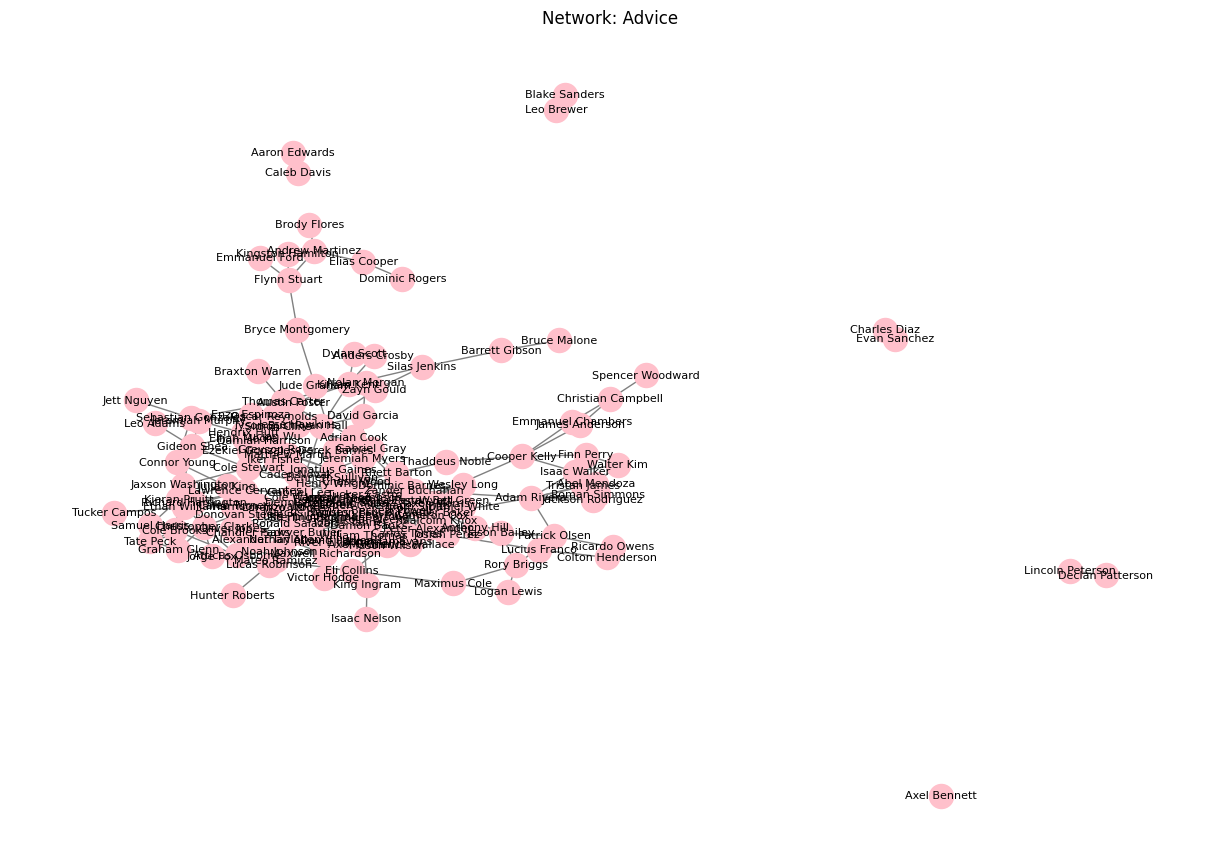

In [22]:
# Load the specific network: net_4_advice
advice_edges_df = pd.read_excel(xls, sheet_name='net_4_Advice')

# Create the graph
advice_edges = nx.Graph()

# Add edges and node attributes
for idx, row in advice_edges_df.iterrows():
    source = row['Source']
    target = row['Target']

    for node in [source, target]:
        if node not in advice_edges:
            if node in participants.index:
                first_name = participants.loc[node, 'First-Name']
                last_name = participants.loc[node, 'Last-Name']
                advice_edges.add_node(node, label=f"{first_name} {last_name}")
            else:
                advice_edges.add_node(node, label="Unknown")

    advice_edges.add_edge(source, target)

advice_edges.remove_edges_from(nx.selfloop_edges(advice_edges))

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(advice_edges, seed=100)

labels = nx.get_node_attributes(advice_edges, 'label')

nx.draw(advice_edges, pos, with_labels=True, labels=labels,
        node_color='pink', node_size=300, font_size=8, edge_color='gray')

plt.title('Network: Advice')
plt.show()

In [23]:
# Use Kamada-Kawai layout to reduce overlap
pos = nx.kamada_kawai_layout(advice_edges)

# === Edge trace ===
edge_x, edge_y = [], []
for source, target in advice_edges.edges():
    x0, y0 = pos[source]
    x1, y1 = pos[target]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='lightgray'),
    hoverinfo='none',
    mode='lines'
)

# === Node trace ===
node_x, node_y, node_text = [], [], []
node_size, node_color = [], []

# Get degree for each node
node_degrees = dict(advice_edges.degree())

for node in advice_edges.nodes():
    x, y = pos[node]
    label = advice_edges.nodes[node].get('label', str(node))
    degree = node_degrees.get(node, 0)

    node_x.append(x)
    node_y.append(y)
    node_size.append(5 + degree * 2)       # Size scaled by degree
    node_color.append(degree)              # Color intensity scaled by degree

    hover_label = f"<b>{label}</b><br>Connections: {degree}"
    node_text.append(hover_label)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='pinkyl',
        cmin=0,
        cmax=max(node_color) if node_color else 1,
        colorbar=dict(
            title='Connections',
            thickness=15,
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=1, color='gray'),
        opacity=0.9
    )
)

# === Final plot ===
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Interactive Network: Advice Seeking Connections",
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

fig.show()

In [24]:
fig.write_html("advice_network_graph.html", full_html=True, include_plotlyjs='cdn')

Disrespect network graph

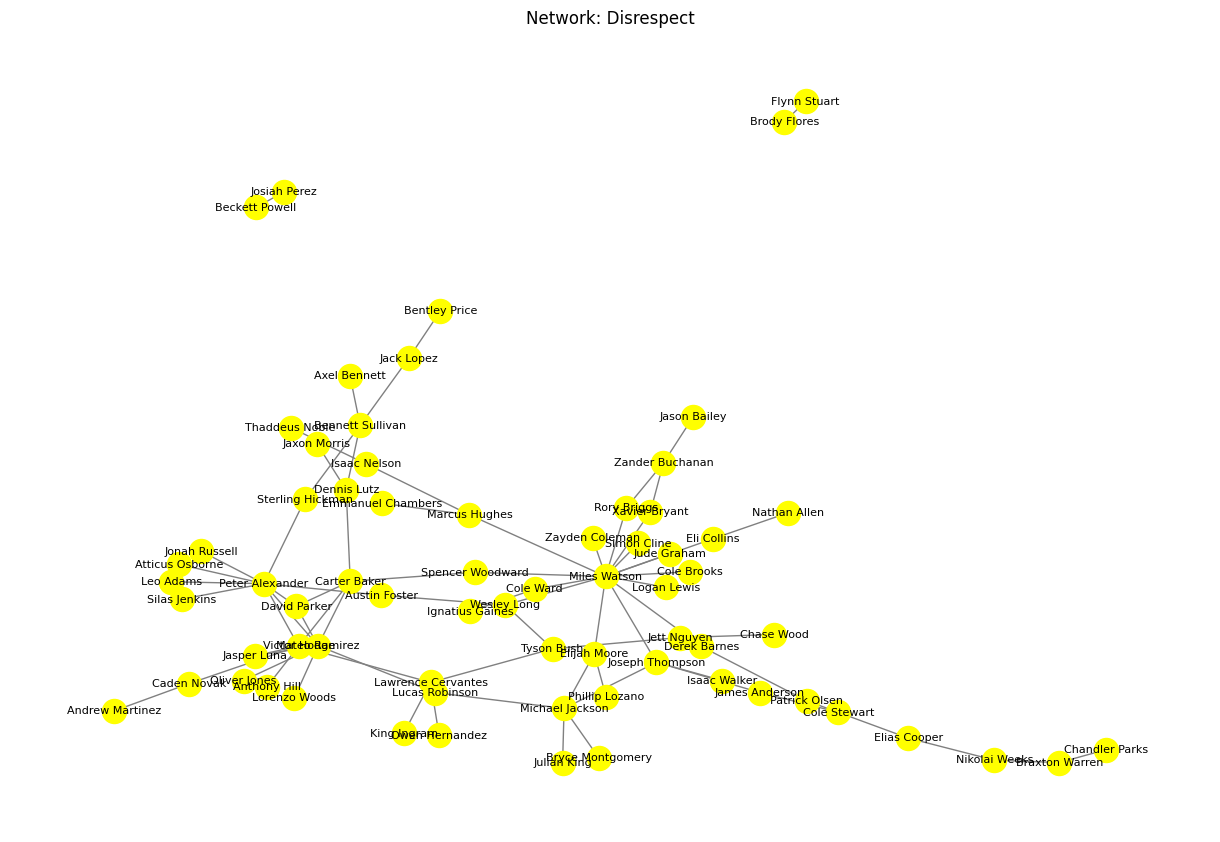

In [25]:
# Load the specific network: net_5_disrespect
disrespect_edges_df = pd.read_excel(xls, sheet_name='net_5_Disrespect')

# Create the graph
disrespect_edges = nx.Graph()

# Add edges and node attributes
for idx, row in disrespect_edges_df.iterrows():
    source = row['Source']
    target = row['Target']

    for node in [source, target]:
        if node not in disrespect_edges:
            if node in participants.index:
                first_name = participants.loc[node, 'First-Name']
                last_name = participants.loc[node, 'Last-Name']
                disrespect_edges.add_node(node, label=f"{first_name} {last_name}")
            else:
                disrespect_edges.add_node(node, label="Unknown")

    disrespect_edges.add_edge(source, target)

disrespect_edges.remove_edges_from(nx.selfloop_edges(disrespect_edges))

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(disrespect_edges, seed=100)

labels = nx.get_node_attributes(disrespect_edges, 'label')

nx.draw(disrespect_edges, pos, with_labels=True, labels=labels,
        node_color='yellow', node_size=300, font_size=8, edge_color='gray')

plt.title('Network: Disrespect')
plt.show()

In [26]:
# Use Kamada-Kawai layout to reduce overlap
pos = nx.kamada_kawai_layout(disrespect_edges)

# === Edge trace ===
edge_x, edge_y = [], []
for source, target in disrespect_edges.edges():
    x0, y0 = pos[source]
    x1, y1 = pos[target]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='lightgray'),
    hoverinfo='none',
    mode='lines'
)

# === Node trace ===
node_x, node_y, node_text = [], [], []
node_size, node_color = [], []

# Get degree for each node
node_degrees = dict(disrespect_edges.degree())

for node in disrespect_edges.nodes():
    x, y = pos[node]
    label = disrespect_edges.nodes[node].get('label', str(node))
    degree = node_degrees.get(node, 0)

    node_x.append(x)
    node_y.append(y)
    node_size.append(5 + degree * 2)       # Size scaled by degree
    node_color.append(degree)              # Color intensity scaled by degree

    hover_label = f"<b>{label}</b><br>Connections: {degree}"
    node_text.append(hover_label)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='Viridis',
        cmin=0,
        cmax=max(node_color) if node_color else 1,
        colorbar=dict(
            title='Connections',
            thickness=15,
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=1, color='gray'),
        opacity=0.9
    )
)

# === Final plot ===
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Interactive Network: Disrespect Connections",
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

fig.show()

In [28]:
fig.write_html("disrespect_network_graph.html", full_html=True, include_plotlyjs='cdn')

Clubs/Associations network graphs

In [40]:
# Load affiliation sheet to map club IDs to names
affiliations = pd.read_excel("Student Survey - Jan.xlsx", sheet_name="affiliations")

# Load the club affiliation data
df_clubs = pd.read_excel("Student Survey - Jan.xlsx", sheet_name="net_affiliation_0_SchoolActivit")

# Rename columns for clarity
df_clubs = df_clubs.rename(columns={"Source": "Participant-ID", "Target": "Club-ID"})

# Merge to get club names
df_clubs = df_clubs.merge(affiliations, left_on="Club-ID", right_on="ID", how="left")

# Count participants per club
club_counts = df_clubs["Club-ID"].value_counts().to_dict()

# Create graph
G = nx.Graph()
for _, row in df_clubs.iterrows():
    participant = row["Participant-ID"]
    club_id = row["ID"]
    club_label = row["Title"]
    member_count = club_counts.get(row["Club-ID"], 0)

    G.add_node(participant, type="student")
    G.add_node(club_id, type="club", label=club_label, members=member_count)
    G.add_edge(participant, club_id)

# Adjust layout for better node spacing
pos = nx.kamada_kawai_layout(G)

# Create node trace
node_trace = go.Scatter(
    x=[pos[n][0] for n in G.nodes()],
    y=[pos[n][1] for n in G.nodes()],
    mode='markers',
    marker=dict(
        size=10,
        color=['orange' if G.nodes[n].get("type") == "club" else 'blue' for n in G.nodes()]
    ),
    text=[f"{G.nodes[n].get('label', n)}<br>Members: {G.nodes[n].get('members', '')}"
          if G.nodes[n].get("type") == "club" else str(n) for n in G.nodes()],
    hoverinfo='text',
    textposition='top center'
)

# Create edge trace
edge_trace = go.Scatter(
    x=sum([[pos[e[0]][0], pos[e[1]][0], None] for e in G.edges()], []),
    y=sum([[pos[e[0]][1], pos[e[1]][1], None] for e in G.edges()], []),
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Final layout
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title="Club Membership Network",
        showlegend=False,
        hovermode='closest',
        plot_bgcolor='rgba(0,0,0,0)',
        width=1000,
        height=800
    )
)

fig.show()

In [42]:
fig.write_html("clubs_network_graph.html", full_html=True, include_plotlyjs='cdn')